# План работы
- Импорт библиотек
- Функции

### 1. Подготовка данных
- Первичное ознакомление с файлами; 
- Проверка расчета эффективности обогащения;
- Анализ мультиколлинеарности;
- Удаление лишних признаков, добавление целевых; 
- Предобработка.

### 2. Анализ данных
- Анализ изменения концентраций металлов (Au, Ag, Pb) на разных этапах очистки;
- Сравнение распределения размеров гранул сырья в обучающей и тестовой выборках;
- Анализ выбросов в суммарной концентрации.  

### 3. Модель
- Разделение датасета на обучающую и тестовую, выделение целевого признака
- Обучение линейной регрессии 
- Подбор гиперпараметров
- Проверка на адекватность
- Тест

# Импорт библиотек

In [1]:
# OS, URL
import os
from urllib.request import urlretrieve

# tables
from IPython.display import display
import pandas as pd

#graphics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(5,4)})

# statistics
import numpy as np

# ML
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

# Функции

Поиск и загрузка файлов

In [2]:
def get_file(file_name, url):
    if not os.path.exists(file_name):
        print('Файл не найден и будет загружен из сети.')
        file_name, headers = urlretrieve(url)
    return pd.read_csv(file_name)

классификация

In [3]:
def me_name(row):
    '''
        find and return metal in row[]
    '''
    for i in ['au', 'pb', 'ag']:
        if i in row['index']:
            return i

def stage_name(row):
    '''
       find and return stage in row
    '''
    for i in ['rougher.input', 'rougher.output','primary_cleaner', 'final']:
        if row['index'].find(i) == 0:
            return i

Расчет sMAPE и итоговое sMAPE

In [4]:
def smape(true, predict):
    true=np.array(true)
    predict=np.array(predict)
    total = 0
    for i in range(len(true)):
        total += abs(true[i] - predict[i]) / ((abs(true[i]) + abs(predict[i]))/2)
    return total*100 / len(true)


def total_smape(rougher_smape, final_smape):
    return 0.25 * rougher_smape + 0.75 * final_smape

# creating quality metric from function smape
smape_score = make_scorer(smape, greater_is_better=False)

поиск параметров

In [5]:
rs = 333 # random_state

def print_GridSearchCV(model, params, features, target, score=smape_score):
    '''prints best parameteres of the model for self-made smape_score.
    '''
    grid = GridSearchCV(model(random_state=rs), params, scoring=score, cv=5)
    grid.fit(features, target)
    print('best parameter: {}'.format(grid.best_params_))

# 1. Подготовка данных

Поместим три датасета в словарь для более удобного доступа к ним

In [6]:
d = {}
for i in ['full', 'train', 'test']:
    file_name = f'/Users/haimo/Documents/data/projects/gold_recovery_{i}.csv.'
    url = f'https://code.s3.yandex.net/datasets/gold_recovery_{i}.csv'
    d[f'raw_data_{i}'] = get_file(file_name, url)
    
    print()
    print(f'gold_recovery_{i}')
    d[f'raw_data_{i}'].info()
    display(d[f'raw_data_{i}'].head())

Файл не найден и будет загружен из сети.

gold_recovery_full
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 n

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Файл не найден и будет загружен из сети.

gold_recovery_train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Файл не найден и будет загружен из сети.

gold_recovery_test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.s

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


- Есть пропуски почти во всех столбцах, 
- Тип столбца date - object
- В тестовом файле 53 признака, тогда как в двух других 87

### Эффективность обогащения
Проверим эффективность обогащения: вычислим вручную и сравним с rougher.output.recovery с помощью метрики MAE.

In [7]:
T = 'rougher.output.tail_au'
C = 'rougher.output.concentrate_au'
F = 'rougher.input.feed_au'

d[f'raw_data_train']['rougher.output.recovery_calc'] = (
    d[f'raw_data_train'][C] * (d[f'raw_data_train'][F] - d[f'raw_data_train'][T]) / 
    (d[f'raw_data_train'][F] * (d[f'raw_data_train'][C] - d[f'raw_data_train'][T])) * 
    100
)

df = d['raw_data_train'][['rougher.output.recovery', 'rougher.output.recovery_calc']].dropna()
mae = mean_absolute_error(df['rougher.output.recovery'],df['rougher.output.recovery_calc'])
mae

9.444891926100695e-15

Разница между исходными и расчетными данными крайне мала, поэтому можем сделать вывод, что эффективность обогощения расчитана верно.

### Недостающие признаки и лишние признаки

Посмотрим каких признаков нет в тестовой выборке.

In [8]:
missing_columns = []
for i in list(d['raw_data_full'].columns):
    if i not in list(d['raw_data_test'].columns):
        missing_columns.append(i)
missing_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

### Анализ мультколлинеарности

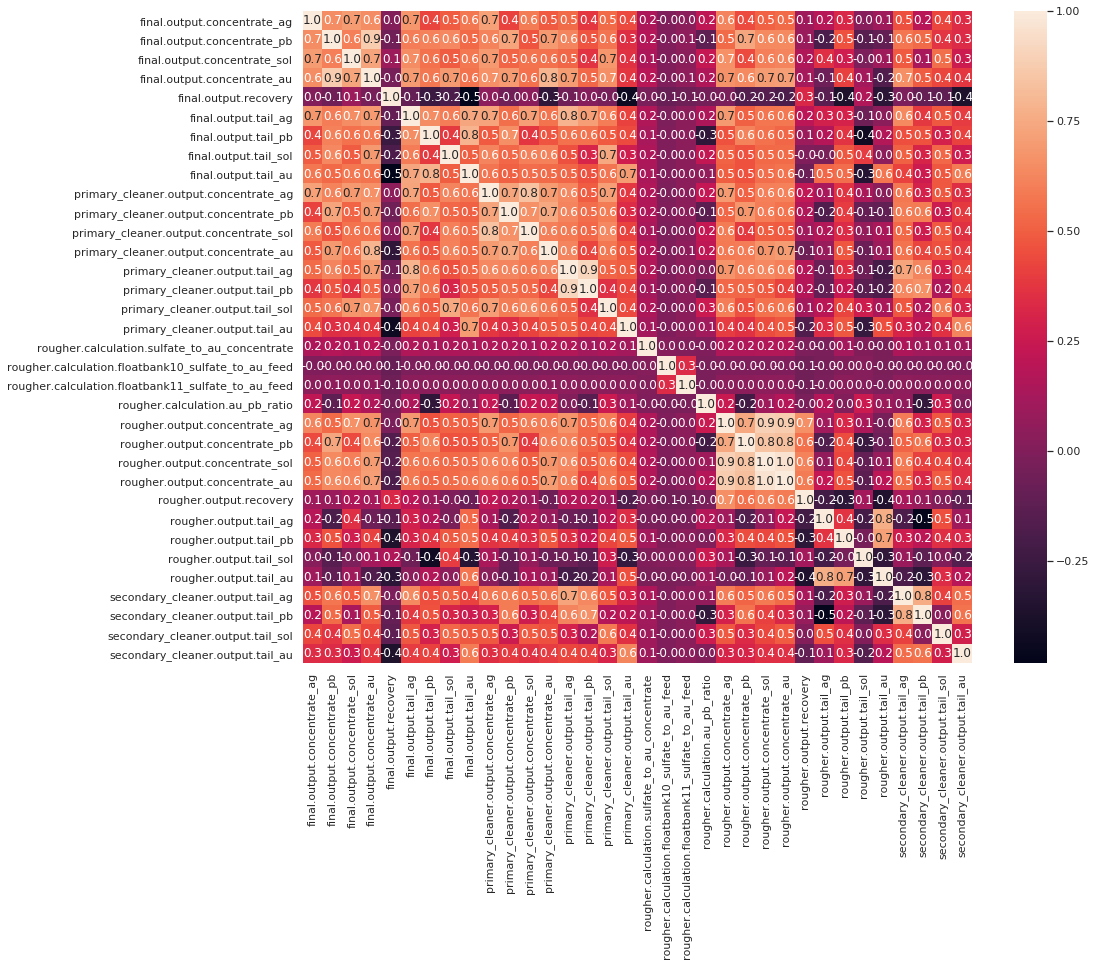

In [9]:
sns.set(rc={'figure.figsize': (15,12)})
sns.heatmap(data=d['raw_data_full'][missing_columns].corr(), annot=True, fmt='0.1f')

В тестовом датасете отсутвуют признаки с результатами концентраций металлов на выходе каждого этапа:    
`rougher.calculation` расчетные характеристики флотации     
`rougher.output` продукт на этапе флотации   
`primary_cleaner.output` на этапе первой очистки   
`secondary_cleaner.output` на этапе второй очистки    
`final.output` коненый результат    
Из которых 2 целевых признака: `rougher.output.recovery`, `final.output.recovery`.

Вероятнее всего эти признаки рассчитываются позднее. Целевые признаки добавим в тестовую выборку, а остальные остуствующие признаки, удалим из обучающей выборки, так как они не описывают состояние технологичесокого процесса, а больше описывают характеристики обрабатываемого сырья, а также содержат информацию о целевом признаке. Наблюдается сильная кореляция некоторых признаков, что также может плохо повлиять на качетсво модели.

In [10]:
# adding target features to test
d['raw_data_test'] = (
    d['raw_data_test']
    .merge(d['raw_data_full'][['date', 'rougher.output.recovery', 'final.output.recovery']], 
           on='date')
)

# deleting features from train
d['raw_data_train'] = d['raw_data_train'][d['raw_data_test'].columns]

In [11]:
d['raw_data_test'].columns

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

### Пропуски

In [12]:
d['raw_data_full'].isnull().sum()

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

Пропусков нет только в столбцах date и primary_cleaner.input.feed_size.    
- Пропуски в целевом признаке удалим, так как их замена может повлиять на результат.    
Причины пропусков в целевом признаке могут быть различные (интересно что именно в целевом больше всего пропусков). Возможно сбой в считывании датчиками или сбой записи

In [13]:
for i in ('train', 'test'):
    d[f'raw_data_{i}'] = d[f'raw_data_{i}'].dropna(subset=['rougher.output.recovery','final.output.recovery'])

- Приведем столбец date к типу datetime и зная что соседние по времени параметры часто похожи, заменим пропуски соседними.

In [14]:
for i in ('train', 'test'):
    d[f'raw_data_{i}']['date'] = pd.to_datetime(d[f'raw_data_{i}']['date'], format='%Y-%m-%dT%H:%M:%S')
    d[f'raw_data_{i}'] = d[f'raw_data_{i}'].sort_values(ascending=True, by='date').fillna(method='ffill')

- Преобразуем тип данных для оптимизации памяти с помощью метода to_numeric().

In [15]:
for i in ('train', 'test', 'full'):
    for j in d[f'raw_data_{i}'].columns:
        if j != 'date':
            d[f'raw_data_{i}'][j] = pd.to_numeric(d[f'raw_data_{i}'][j], downcast='float')

### Выводы:
- Проверили эффективность насыщения, посчитана верно
- Убрали лишние признаки из тренировочного датасета и добавили целевые признаки в тестовый.
- Строки с пропусками в целевых признаках удалили, остальные пропуски заполнили соседними
- Столбец date привели к типу DateTime
- Остальные - к float32

# 2. Анализ данных

### Изменение концентраций металлов (Au, Ag, Pb) на разных этапах очистки

Сохраним названия столбцов, где есть в названии металл в переменной `metal_columns`

In [16]:
metals = ['au', 'ag', 'pb']
stages = ['rougher.input', 'rougher.output','primary_cleaner', 'final']

metal_columns = []
for col in list(d['raw_data_full'].columns):
    for Me in metals:
        if Me in col.split('_') and col.find('rougher.calculation.') == -1 and col.find('tail') == -1:
            metal_columns.append(col)

metal_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au']

Выделим из названий столбцов названия металлов и этапов, и сгруппируем таблицу по названию металла.

In [17]:
df = pd.DataFrame(d['raw_data_full'][metal_columns].mean().reset_index()
                  .set_axis(['index', 'concentration'], axis=1, inplace=False))
df['metal'] = df.apply(me_name, axis=1)
df['stage'] = df.apply(stage_name, axis=1)
df = df.drop('index', axis=1)
df

,concentration,metal,stage
0,4.781523,ag,final
1,9.095406,pb,final
2,40.000706,au,final
3,7.691781,ag,primary_cleaner
4,8.921241,pb,primary_cleaner
5,29.212112,au,primary_cleaner
6,8.065827,ag,rougher.input
7,3.305656,pb,rougher.input
8,7.565935,au,rougher.input
9,10.874626,ag,rougher.output


Посмотрим на изменение концентрации каждого металла на каждом этапе

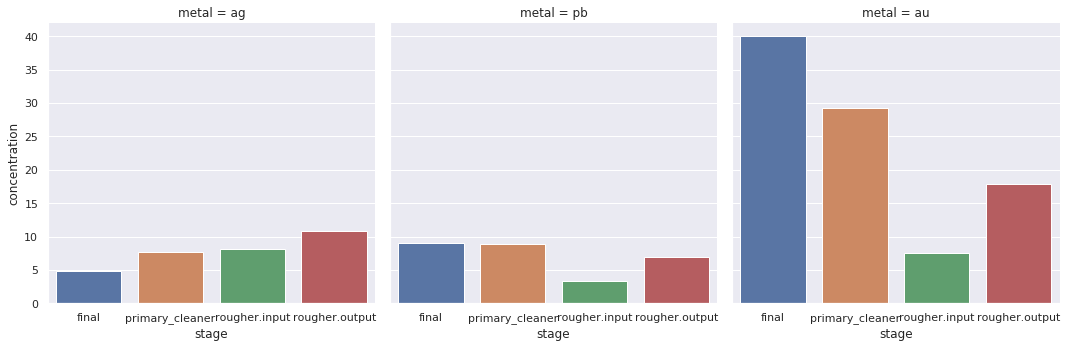

In [18]:
sns.catplot(data=df, kind='bar',x='stage', y='concentration', col='metal')

Из графиков видно, что концентрация золота увеличивается на каждом этапе, что говорит об эффективности тех процессов.   
На выходе концентрация золота в 4 раза больше, чем в исходном сырье.     
Концентрация серебра увеличивается только на этапе флотации, на этапах очистки снижается и на выходе минимальна.   
Концентрация свинца увеличивается на этапе флотации и потом не изменяется, и на выходе в 2 раза выше, чем в исходном сырье.  

### Сравнение распределения размеров гранул сырья в обучающей и тестовой выборках

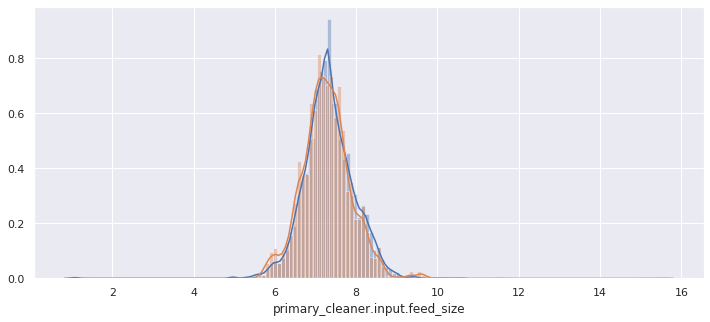

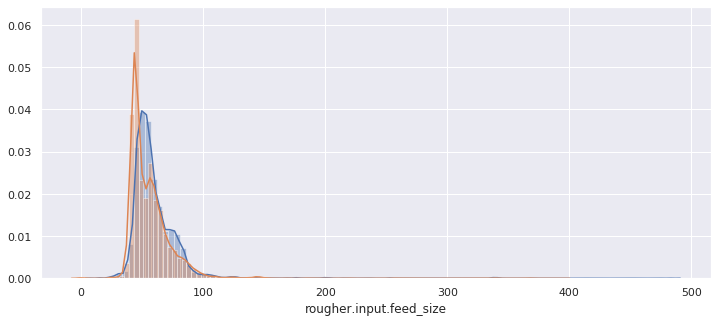

In [19]:
sns.set(rc={'figure.figsize':(12,5)})

feed_size_columns = []
for i in list(d['raw_data_full'].columns):
    if i.find('feed_size') != -1:
        feed_size_columns.append(i)

for col in feed_size_columns:
    sns.distplot(d['raw_data_train'][col], bins=100, kde=True)
    sns.distplot(d['raw_data_test'][col], bins=100, kde=True)
    plt.show()

Размер гранул в тренировочном и тестовом датасете близки

### Анализ выбросов в суммарной концентрации

In [20]:
df_stages = d['raw_data_full'][metal_columns]

df_stages['final'] = (
    df_stages['final.output.concentrate_ag'] + 
    df_stages['final.output.concentrate_au'] + 
    df_stages['final.output.concentrate_pb']
)

df_stages['rougher.input'] = (
    df_stages['rougher.input.feed_ag'] + 
    df_stages['rougher.input.feed_pb'] + 
    df_stages['rougher.input.feed_au']
)

df_stages['rougher.output'] = (
    df_stages['rougher.output.concentrate_ag'] + 
    df_stages['rougher.output.concentrate_pb'] + 
    df_stages['rougher.output.concentrate_au']
)

df_stages['primary_cleaner'] = (
    df_stages['primary_cleaner.output.concentrate_ag'] + 
    df_stages['primary_cleaner.output.concentrate_pb'] + 
    df_stages['primary_cleaner.output.concentrate_au']
)

df_stages = df_stages[stages]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

Text(0.5, 0, 'concentration')

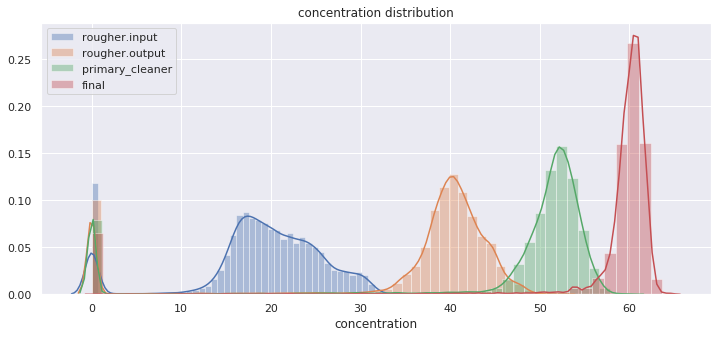

In [21]:
df_stages = df_stages.dropna()
for i in stages:
    sns.distplot(df_stages[i], label=i)
plt.legend()
plt.title('concentration distribution')
plt.xlabel('concentration')

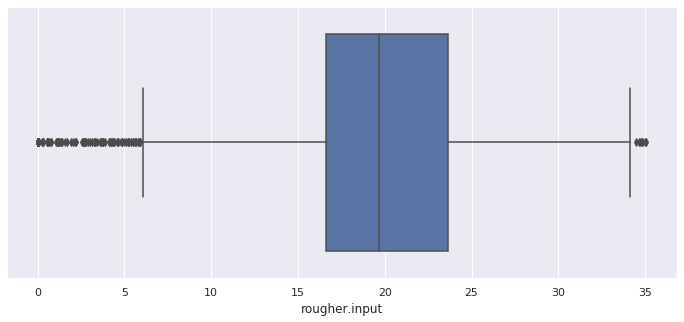

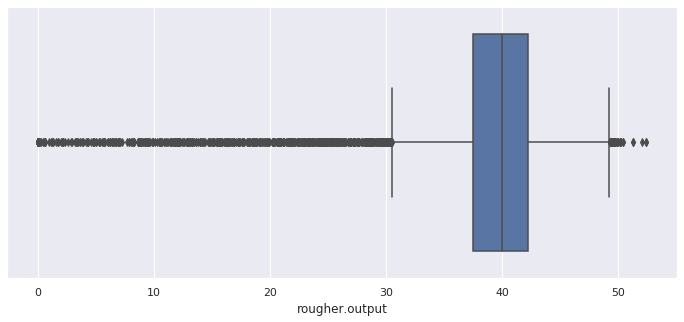

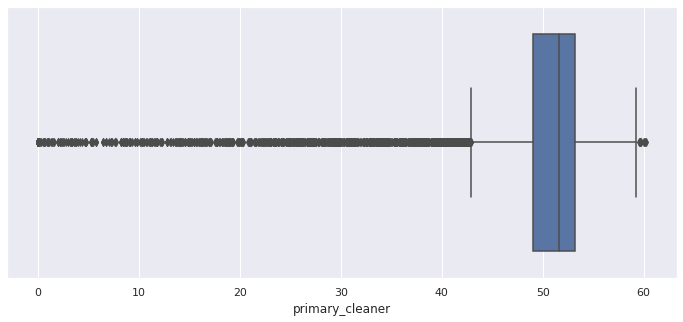

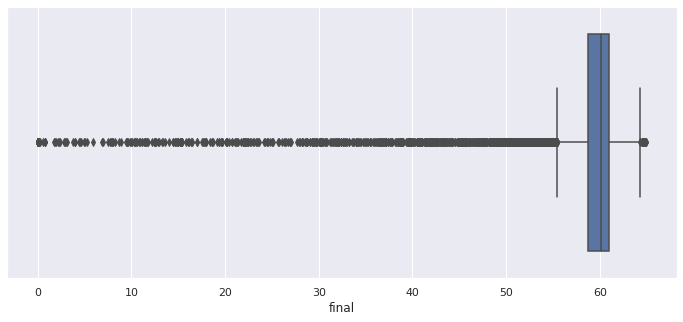

In [22]:
for i in stages:
    sns.boxplot(df_stages[i])
    plt.show()

На графике видно как сумма концентрацции всех металов и хвост выбросов растет с каждым этапом. На самом деле выбросом или аномалией это назвать сложно, а вот ярковыраженный пик в значении нуля уже похоже на аномалию и технический сбой. 

Выбросы могут повлиять на качество модели, поэтому уберем все нулевые значения и сохраним очищенные датасеты в `train` и `test`.

In [23]:
df_stages = df_stages[(df_stages['rougher.input'] > 0) & 
                      (df_stages['rougher.output'] > 0) & 
                      (df_stages['primary_cleaner'] > 0) & 
                      (df_stages['final'] > 0)]

dates = d['raw_data_full'].loc[df_stages.index]['date']

train = d['raw_data_train'].query('date in @dates')
test = d['raw_data_test'].query('date in @dates')

### Выводы:
- Концентрация золота на кажом этапе растет
- Распределение размеров гранул в тренировочном и тестовом датасете одинаковый
- Треничровный и тестовый датасеты очищены от выбросов и сохранены в `train` и `test`

# 3. Модель

### Разделение датасета 
Выделим целевой признак

In [24]:
# train dataset with 2 targets
features_train = train.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_rougher = train['rougher.output.recovery']
target_train_final = train['final.output.recovery']

# test dataset with 2 targets
features_test = test.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_rougher = test['rougher.output.recovery']
target_test_final = test['final.output.recovery']

### Линейная регрессия
В качестве первого испытания обучим модель линейной регрессии

In [25]:
smape_rougher = np.mean(cross_val_score(LinearRegression(), features_train, 
                                        target_train_rougher, scoring=smape_score, 
                                        cv=5, n_jobs=-1))
smape_final = np.mean(cross_val_score(LinearRegression(), features_train, 
                                      target_train_final, scoring=smape_score, 
                                      cv=5, n_jobs=-1))
print('Итоговой sMAPE:',total_smape(smape_rougher, smape_final))

Итоговой sMAPE: -9.750776243401958


### Подбор гиперпараметров

Обучим дерево и настроим гиперпараметры.

In [26]:
tree_params = {
    'max_depth': range(1,11),
    'min_samples_leaf': range(1,11),
    'min_samples_split': range(2,11)
}

print('целевой признак: rougher.output.recovery')
print_GridSearchCV(DecisionTreeRegressor, tree_params, features_train, target_train_rougher)
print('целевой признак: final.output.recovery')
print_GridSearchCV(DecisionTreeRegressor, tree_params, features_train, target_train_final)

# best parameter: {'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 2}
# best parameter: {'max_depth': 2, 'min_samples_leaf': 1}

целевой признак: rougher.output.recovery
best parameter: {'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 2}
целевой признак: final.output.recovery
best parameter: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [27]:
smape_rougher = np.mean(cross_val_score(DecisionTreeRegressor(max_depth=3, min_samples_leaf=3,
                                                              min_samples_split=4, random_state=rs), 
                                        features_train, target_train_rougher, scoring=smape_score, 
                                        cv=5))
smape_final = np.mean(cross_val_score(DecisionTreeRegressor(max_depth=3, min_samples_leaf=1,
                                                            min_samples_split=2, random_state=rs), 
                                      features_train, target_train_final, scoring=smape_score,
                                      cv=5))
print(smape_rougher, smape_final)
print('Итоговый sMAPE:', total_smape(smape_rougher, smape_final))
# Итоговый sMAPE: 8.54

-7.1111138563177025 -9.290174229916403
Итоговый sMAPE: -8.745409136516727


Обучим лес и настроим гиперпараметры.

In [28]:
forest_params = {
    'n_estimators': np.arange(11, 51, 10),
    'max_depth': np.arange(1, 11),
}

print('целевой признак: rougher.output.recovery')
print_GridSearchCV(RandomForestRegressor, forest_params, features_train, target_train_rougher)
print('целевой признак: final.output.recovery')
print_GridSearchCV(RandomForestRegressor, forest_params, features_train, target_train_final)

# best parameter: {'max_depth': 5, 'n_estimators': 11}
# best parameter: {'max_depth': 4, 'n_estimators': 41}

целевой признак: rougher.output.recovery
best parameter: {'max_depth': 5, 'n_estimators': 11}
целевой признак: final.output.recovery
best parameter: {'max_depth': 4, 'n_estimators': 41}


In [29]:
smape_rougher = np.mean(cross_val_score(RandomForestRegressor(max_depth=5, n_estimators=11, random_state=rs), 
                                        features_train, target_train_rougher, scoring=smape_score, cv=5))
smape_final = np.mean(cross_val_score(RandomForestRegressor(max_depth=5, n_estimators=11, random_state=rs), 
                                      features_train, target_train_final, scoring=smape_score, cv=5))
print(smape_rougher, smape_final)
print('Итоговый sMAPE:', total_smape(smape_rougher, smape_final))

-6.184747797963865 -8.827478556617512
Итоговый sMAPE: -8.1667958669541


### Проверка на адекватность

In [30]:
sanity_check = pd.Series([target_train_rougher.mean() for i in range(len(target_train_rougher))])
smape_rougher = smape(target_train_rougher, sanity_check)

sanity_check = pd.Series([target_train_final.mean() for i in range(len(target_train_final))])
smape_final = smape(target_train_final, sanity_check)

print('Итоговый sMAPE:', total_smape(smape_rougher, smape_final))

Итоговый sMAPE: 9.158100587924011


### Проверка на тестовой выборке

In [31]:
model = RandomForestRegressor(max_depth=5, n_estimators=11, random_state=rs)
model.fit(features_train, target_train_rougher)
predicted = model.predict(features_test)
smape_rought = smape(target_test_rougher, predicted)

model = RandomForestRegressor(max_depth=5, n_estimators=11, random_state=rs)
model.fit(features_train, target_train_final)
predicted = model.predict(features_test)
smape_final = smape(target_test_final, predicted)

print('Итоговое sMAPE:', total_smape(smape_rougher, smape_final))

Итоговое sMAPE: 7.859188481003875


# Выводы:

Мы рассмотрели 3 модели: LR, DT и RFR. В качестве метрики качества модели использовали sMAPE(симметричное среднее абсолютное процентное отклонение). Цель проекта - минимизация метрики total smape. Лучший результат на тестовой выборке в 7.08 достигнут с помощью модели случайного леса, что отличается от константной модели, расчитанной средним (итоговый sMAPE = 9,16).